# `CLOUD.jl` - 1D linear advection

In [2]:
using CLOUD
using OrdinaryDiffEq
using TimerOutputs
plots_path = "../plots/advection_dgsem_1D/"
results_path = "../results/advection_dgsem_1D/";

Define the physical problem (advection of a sine wave)

In [3]:
a = 1.0  # advection velocity
A = 1.0  # amplitude
L = 1.0  # domain length
k = 4*π/L  # wave number
T = 1*L/a  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation(a,λ=1.0);

Set up a strong-form DGSEM-LGL scheme of degree `p` with `M` elements and periodic boundary conditions

In [4]:
M = 4  # number of elements
p = 3  # degree of discretization
reference_approximation=ReferenceApproximation(
    DGSEM(p), Line(), quadrature_rule=LGLQuadrature())
spatial_discretization = SpatialDiscretization(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    (0.0,L), M), reference_approximation)
results_path = save_project(conservation_law,
     spatial_discretization, initial_data, WeakConservationForm(), 
     (0.0, T), Lazy(), results_path, overwrite=true, clear=true);

Run the `OrdinaryDiffEq` solver, taking `n_s` snapshots

In [5]:
reset_timer!()
n_s = 10
dt_scale = 0.01
dt = dt_scale*(L/M)/(a*(2*p+1))
ode_problem = semidiscretize(load_project(results_path)...)
save_solution(ode_problem.u0, 0.0, results_path, 0)
sol = solve(ode_problem, RK4(), adaptive=false, 
    dt=dt, save_everystep=false,
    callback=save_callback(results_path, ceil(Int, T/(dt*n_s))))
save_solution(last(sol.u), last(sol.t), results_path, "final");
print_timer()

 ──────────────────────────────────────────────────────────────────────────────
                                       Time                   Allocations      
                               ──────────────────────   ───────────────────────
       Tot / % measured:            13.8s / 10.7%           2.26GiB / 13.9%    

 Section               ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 rhs!                   11.2k    1.48s   100%   132μs    323MiB  100%   29.5KiB
   eval residual        44.9k    663ms  44.8%  14.8μs    151MiB  46.7%  3.44KiB
     facet terms        44.9k    264ms  17.8%  5.88μs   72.4MiB  22.4%  1.65KiB
     volume terms       44.9k    124ms  8.41%  2.77μs   51.3MiB  15.9%  1.17KiB
     mass matrix solve  44.9k   7.56ms  0.51%   168ns   4.79MiB  1.48%     112B
   eval numerical flux  44.9k    213ms  14.4%  4.75μs   78.7MiB  24.4%  1.80KiB
   extrapolate solu...  44.9k    141ms 

Visualize the solution

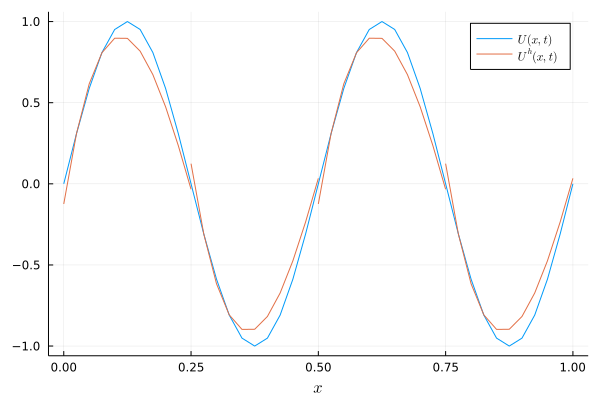

In [6]:
plotter = Plotter(spatial_discretization, plots_path)
visualize(last(sol.u), plotter, "solution.pdf", exact_solution=initial_data,
    label="U^h(x,t)", label_exact="U(x,t)")

Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [7]:
error_analysis = ErrorAnalysis(conservation_law, 
    spatial_discretization, 
    results_path)
print("L2 error: ", analyze(error_analysis, last(sol.u), initial_data)[1])

conservation_analysis = PrimaryConservationAnalysis(conservation_law, 
    spatial_discretization, 
    results_path)
println("Conservation (initial/final/diff):\n", analyze(conservation_analysis)...)

energy_analysis = EnergyConservationAnalysis(conservation_law, 
    spatial_discretization, 
    results_path)
println("Energy (initial/final/diff):\n",analyze(energy_analysis)...)

L2 error: 0.09362246144060996Conservation (initial/final/diff):
[1.1102230246251565e-16][3.0531133177191805e-16][1.942890293094024e-16]
Energy (initial/final/diff):
[0.4854476399019001][0.4155056551843309][-0.06994198471756918]
